In [1]:
import sys
print(sys.executable)

/home/ubuntu/anaconda3/envs/shun/bin/python


In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
torch.cuda.set_device(0)

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/camvid/labels'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/images'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/codes.txt')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/ubuntu/.fastai/data/camvid/images/Seq05VD_f03030.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/images/Seq05VD_f02670.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/images/0001TP_007530.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/ubuntu/.fastai/data/camvid/labels/0006R0_f02130_P.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels/Seq05VD_f04920_P.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels/0016E5_08061_P.png')]

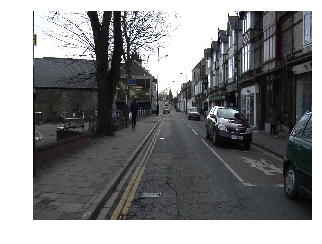

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

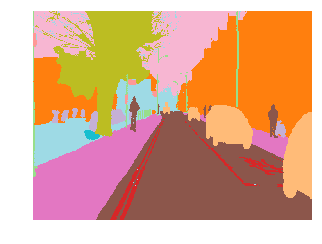

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 8,  8,  8,  ...,  4,  4,  4],
          [ 8,  8,  8,  ...,  4,  4,  4],
          [ 8,  8,  8,  ...,  4,  4,  4],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [12]:
size = src_size//2
bs=8

In [13]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [14]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

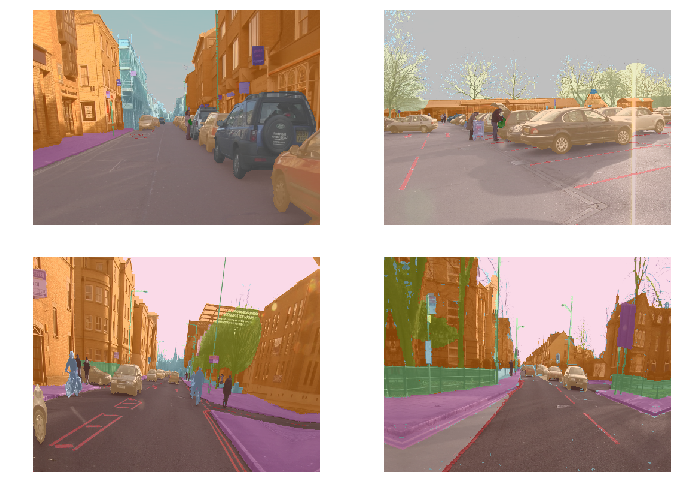

In [15]:
data.show_batch(2, figsize=(10,7))

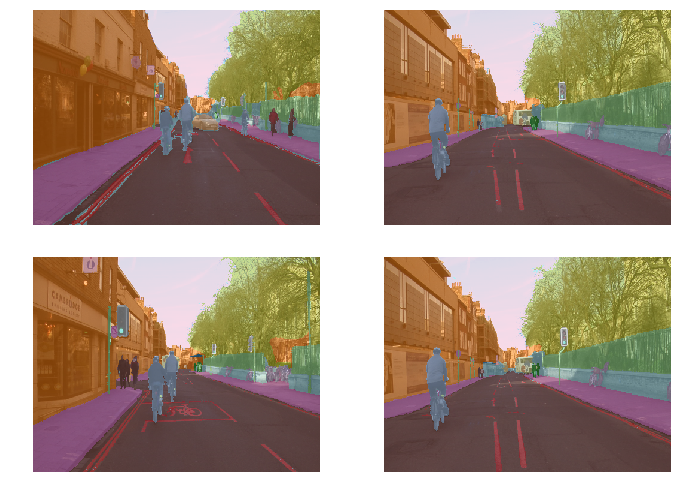

In [16]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [15]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [16]:
metrics=acc_camvid

In [17]:
wd=1e-2

In [26]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


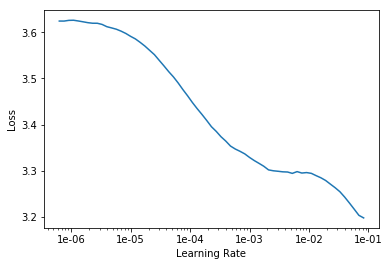

In [24]:
lr_find(learn)
learn.recorder.plot()

In [25]:
lr=3e-3

In [26]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid
1,2.817714,2.697040,0.607527
2,2.631366,2.456794,0.732327
3,2.446777,2.236912,0.832686
4,2.232693,2.027800,0.847939
5,1.968686,1.647570,0.873237
6,1.646062,1.297290,0.867862
7,1.338571,1.110550,0.886864
8,1.079668,0.764934,0.884212
9,0.854650,0.634875,0.897980
10,0.688004,0.521351,0.919327


In [27]:
learn.save('stage-1')

In [28]:
learn.load('stage-1');

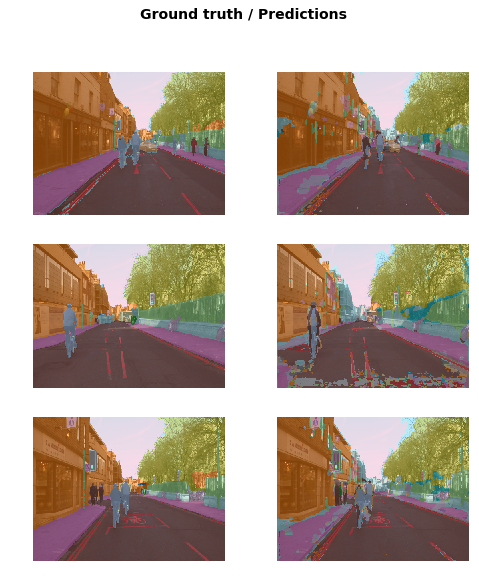

In [29]:
learn.show_results(rows=3, figsize=(8,9))

In [30]:
learn.unfreeze()

In [31]:
lrs = slice(lr/400,lr/4)

In [32]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.597843,0.533282,0.917168
2,0.587154,0.518559,0.918615
3,0.569844,0.522997,0.915794
4,0.559691,0.521534,0.917399
5,0.547753,0.478493,0.920766
6,0.519907,0.496341,0.914103
7,0.500648,0.433064,0.921307
8,0.471075,0.426144,0.919643
9,0.449670,0.410527,0.920782
10,0.424927,0.399000,0.916777


In [33]:
learn.save('stage-2');

In [18]:
size = src_size
bs=2

In [19]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [20]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [21]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


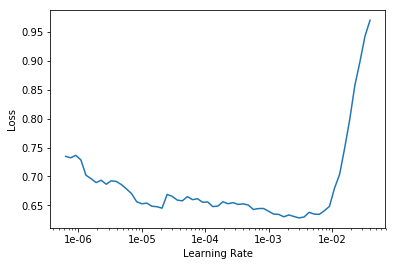

In [22]:
lr_find(learn)
learn.recorder.plot()

In [23]:
lr=1e-3

In [24]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.583513,0.395217,0.918326
2,0.518526,0.399064,0.916805
3,0.501866,0.375720,0.922156
4,0.482042,0.393478,0.913544
5,0.450091,0.335141,0.922873
6,0.444465,0.312215,0.930816
7,0.418129,0.316196,0.921269
8,0.362987,0.331949,0.920920
9,0.317322,0.288964,0.924269
10,0.272605,0.272594,0.930357


In [25]:
learn.save('stage-1-big')

In [26]:
learn.load('stage-1-big');

In [27]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.254679,0.275074,0.930256
2,0.259232,0.287755,0.927427
3,0.264390,0.290626,0.928106
4,0.256351,0.271760,0.933201
5,0.301627,0.281213,0.926146
6,0.285649,0.331070,0.915243
7,0.282145,0.312887,0.919738
8,0.269031,0.353223,0.912846
9,0.268272,0.291236,0.926601
10,0.212833,0.272329,0.930836


In [28]:
learn.save('stage-2-big')

In [29]:
learn.load('stage-2-big')

Learner(data=ImageDataBunch;

Train: LabelList
y: SegmentationLabelList (600 items)
[ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960)]...
Path: /home/ubuntu/.fastai/data/camvid/images
x: SegmentationItemList (600 items)
[Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960)]...
Path: /home/ubuntu/.fastai/data/camvid/images;

Valid: LabelList
y: SegmentationLabelList (101 items)
[ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960)]...
Path: /home/ubuntu/.fastai/data/camvid/images
x: SegmentationItemList (101 items)
[Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960)]...
Path: /home/ubuntu/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), str

In [30]:
learn.unfreeze()

In [31]:
lrs = slice(1e-6,lr/10)

In [32]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.210750,0.267136,0.931951
2,0.208953,0.263673,0.931944
3,0.191533,0.271293,0.932057
4,0.208512,0.282725,0.928857
5,0.193233,0.292749,0.929104
6,0.186607,0.293168,0.930501
7,0.185420,0.277293,0.933807
8,0.182475,0.275160,0.933163
9,0.183233,0.271719,0.934143
10,0.181016,0.284276,0.932012


In [33]:
learn.save('stage-3-big')

In [34]:
learn.load('stage-3-big')

Learner(data=ImageDataBunch;

Train: LabelList
y: SegmentationLabelList (600 items)
[ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960)]...
Path: /home/ubuntu/.fastai/data/camvid/images
x: SegmentationItemList (600 items)
[Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960)]...
Path: /home/ubuntu/.fastai/data/camvid/images;

Valid: LabelList
y: SegmentationLabelList (101 items)
[ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960)]...
Path: /home/ubuntu/.fastai/data/camvid/images
x: SegmentationItemList (101 items)
[Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960)]...
Path: /home/ubuntu/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), str

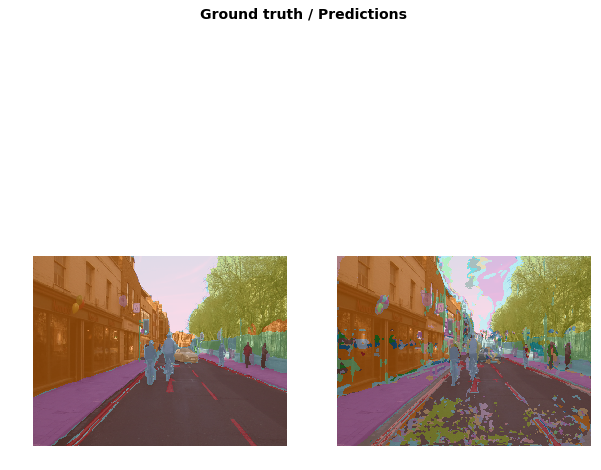

In [39]:
learn.show_results(rows=1, figsize=(10,10))